In [1]:
import uavgeo as ug
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import os
import pandas as pd

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


1. final processing to acquire correct format 
2. randomForest.predict() on all three sets
3. generate risk map



# 1. Rerun BBR Implementation


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
from sklearn.metrics import accuracy_score

In [3]:
# open preprocessed 2021 data from Ariza et al. 2023

train_2021 = pd.read_csv("../data/input_train_randomForest.csv")
training_set = train_2021.drop(["status", "Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0", "plantID"], axis=1)
training_labels = train_2021["status"]

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=1000,
                                        random_state=8,
                                        n_jobs=4,
                                        max_depth=15)

forest.fit(training_set, training_labels)


# 3. BBR on Canyelles dataset

# 3.1. can2023 preprocessing

In [1]:
ndvi = rxr.open_rasterio("../data/preprocessed/ndvi.tif")
chm= rxr.open_rasterio("../data/preprocessed/chm.tif")
dsm= rxr.open_rasterio("../data/preprocessed/dsm.tif")
dem= rxr.open_rasterio("../data/preprocessed/dem.tif")
rgb= rxr.open_rasterio("../data/preprocessed/rgb.tif")

NameError: name 'rxr' is not defined

In [11]:
# Shadows/LAI implementation
shadows = ug.compute.calc_vineyard_shadows(rgb, band_id =1)

In [12]:
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)

In [13]:

# only extract NDVI from thwere there are vine plants
vines_ndvi = ndvi.where(vines_mask)
vines_ndvi_mask = vines_ndvi<1
vines_ndvi = vines_ndvi.where(vines_ndvi_mask)
vines_ndvi= vines_ndvi.rio.write_nodata(vines_ndvi.rio.nodata, encoded = True)

## 3.2. extract the values 
* programatically create the 2.5x3 plants-grid: nah manually do it in qgis: this can be done later for uavgeo
* 
* extract all the correct values from the rasters to this plant.geojson
    * count_shadow,
    * min_CHM, max_CHM, mean_CHM, std_CHM, median_CHM, count_CHM
    * min_NDVI, max_NDVI, mean_NDVI, std_NDVI, median_NDVI, count_NDVI
    * min_DTM, max_DTM, mean_DTM, std_DTM, median_DTM
* repeat extraction for NDVI, fakeNDVI, fakeNDVI-HD

In [14]:
t = gpd.read_file("../data/plants.geojson")

In [15]:
# set dtm values to the same range as btg2021, as a sort of normalization step:
rmin = 202.03 #dem.min()
rmax = 213.79
tmin =63.30893
tmax = 87.72105
dem = ((dem-rmin)/(rmax-rmin)) * (tmax-tmin) + tmin

In [16]:
#extract values, as based from the BBR paper

ndvi_df = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi,  stats = ["min", "max", "mean", "std", "median", "count"],  prefix = "NDVI_")
chm_df = ug.compute.extract_features(gpd_df=t, xr=vines_chm,stats = ["min", "max", "mean", "std", "median", "count"], prefix= "CHM_")
dtm_df = ug.compute.extract_features(gpd_df=t, xr=dem, stats = ["min", "max", "mean", "std", "median"], prefix="DTM_")
shadows_df = ug.compute.extract_features(gpd_df=t, xr=shadows, stats=["count"], prefix="SHADOWS_")


In [17]:
#drop lowest 10 percent of shadows/LAI as it is essentially noise
lowest_10percent = shadows_df["SHADOWS_count"].nsmallest(int(len(shadows_df)/10))
shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0

C:\Users\judoj\AppData\Local\Temp\ipykernel_18792\4214284385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shadows_df["SHADOWS_count"].loc[lowest_10percent.index] = 0


In [18]:
# join the DFs in to real, fake, fakeHD
real = pd.merge(left = ndvi_df,right= chm_df, on = "id") 
real = pd.merge(left=real, right = dtm_df, on = "id")
real = real.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)
real = pd.merge(left=real, right = shadows_df, on = "id")
real = real.drop(["left_x", "top_x", "right_x", "bottom_x", "left_y", "top_y", "right_y", "bottom_y"], axis =1)

## 3.3. predict on the values, and generate KDE rasters

In [20]:
colname_remap = {
    'NDVI_min': "min_NDVI",
    'NDVI_max': "max_NDVI",
    'NDVI_mean': "mean_NDVI",
    'NDVI_count': "count_NDVI",
    'NDVI_std': "std_NDVI",
    'NDVI_median': "median_NDVI",
    'CHM_min': "min_CHM",
    'CHM_max': "max_CHM",
    'CHM_mean': "mean_CHM",
    'CHM_count': "count_CHM",
    'CHM_std': "std_CHM",
    'CHM_median': "median_CHM",
    'DTM_min': "min_DTM",
    'DTM_max': "max_DTM",
    'DTM_mean': "mean_DTM",
    'DTM_std': "std_DTM",
    'DTM_median': "median_DTM",
    'SHADOWS_count': "count_shadow"
}

In [21]:
real = real.rename(columns = colname_remap)

In [22]:
rf_real_n = real

In [23]:
#prep dataset to go into forest.predict()
#requires training_set from first code-box above.

rf_real_n = rf_real_n[training_set.columns].fillna(0)

In [24]:
# apply the Random Forest model trained above to the dataset
real["status"] = forest.predict(rf_real_n)

In [25]:
# rejoin the geometries from the grid/plants dataset for a visual representation
real_pred= t.merge(real, on = "id")[["geometry","id", "status"]]

In [26]:
# export the predictions to file, ready for KDE mapping onto a raster.
real_pred = real_pred.set_geometry(real_pred.geometry.centroid)
real_pred.to_file("../data/pred_kde_input.geojson")


## Kernel Density Mapping: 'generate heatmap' 
Might require a different environment, as there are some incompatabilites between uavgeo and spatial_kernel_density package.

In [ ]:
import geopandas as gpd
from spatial_kde import spatial_kernel_density
real = gpd.read_file("../data/pred_kde_input.geojson")

heatmap_tif = "../data/bot_heatmap.tif"
data = real[real["status"]=="Botrytis"].reset_index()
spatial_kernel_density(data, radius = 15,
                        output_pixel_size=0.1, 
                       output_path=heatmap_tif, 
                       output_driver="GTiff")


## 3.4 Visualize KDE maps


In [23]:
# loading KDE maps:

real_heatmap = rxr.open_rasterio("../data/bot_heatmap.tif")
rgb= rxr.open_rasterio("../data/preprocessed/rgb.tif")

In [25]:
# only extract heatmap values above 0

real_heatmap_mask = real_heatmap>0.01
real_heatmap = real_heatmap.where(real_heatmap_mask)
real_heatmap = real_heatmap.rio.write_nodata(real_heatmap.rio.nodata, encoded = True)

In [26]:
#the resoltuion might be a bit high 
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


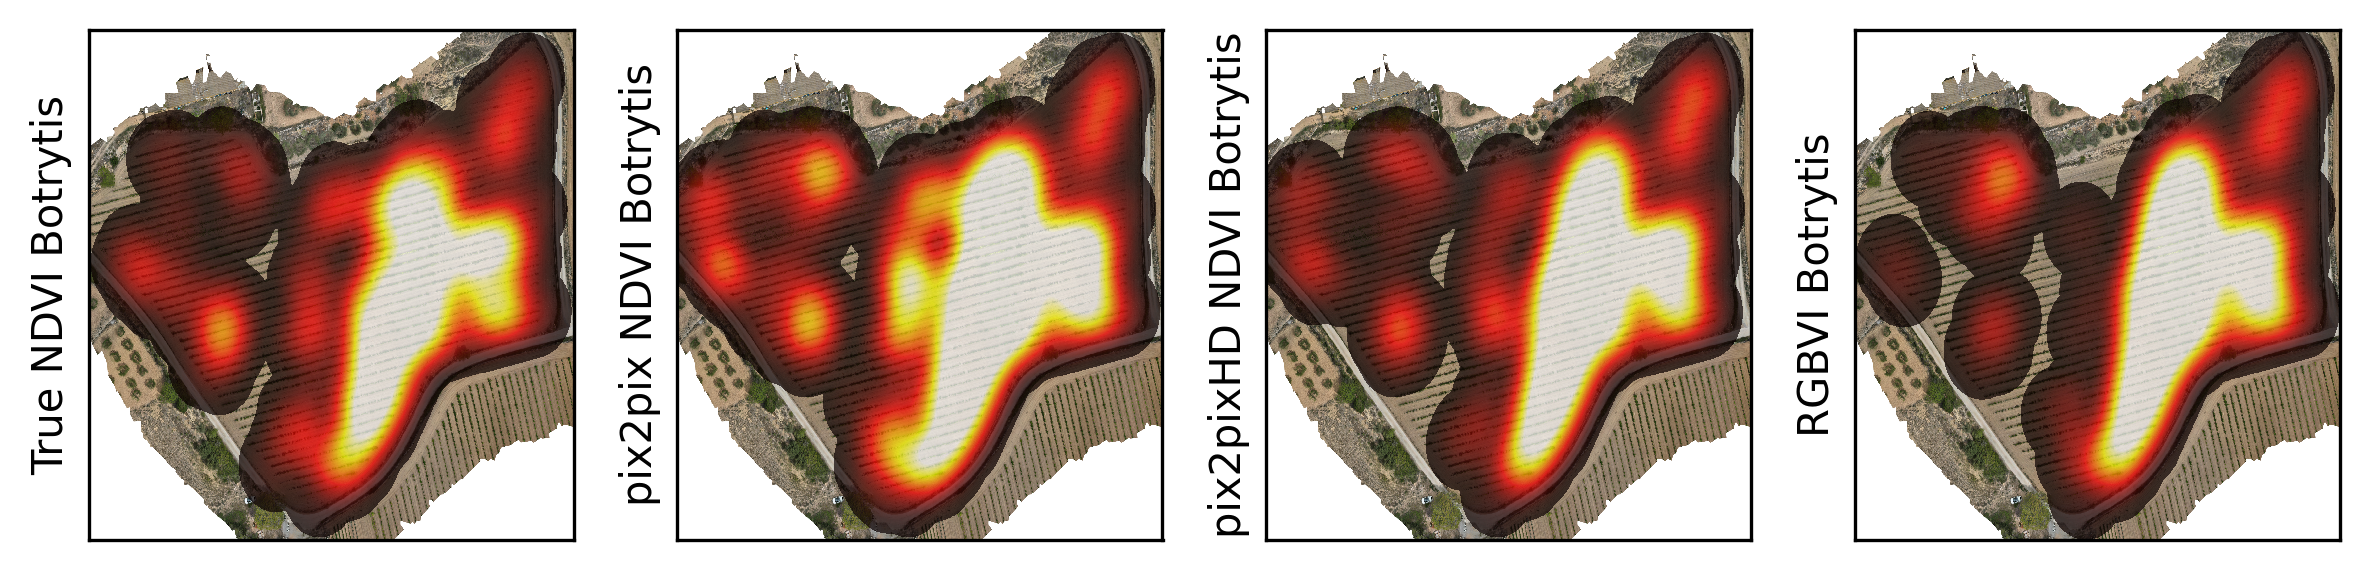

In [27]:

fig,ax = plt.subplots(figsize=(8,5),nrows =1, ncols = 1,dpi=300)

bounds = real_heatmap.rio.bounds()

rgb_down.plot.imshow(ax=ax,add_colorbar=False)
real_heatmap.plot(ax=ax, vmin =0, vmax = 20, alpha =0.7, cmap ="hot", add_colorbar= False)
real.plot(ax=ax, column = "status")

ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("True NDVI Botrytis")
ax.set_xlim(bounds[0],bounds[2])
ax.set_ylim(bounds[1],bounds[3])


plt.tight_layout()
plt.savefig("figures/can2023_bot_risk.png")
plt.show()